In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

In [11]:
df = pd.read_csv('Data/costSensitive.csv')

In [12]:
df.columns

Index(['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS',
       'AH', 'AN', 'Status', 'FNC'],
      dtype='object')

In [13]:
data = df.values
print(data.shape)

(147636, 13)


In [14]:
X = data[:, :-2]

# Normalize the data (Z-score)
X = (X - X.mean(axis=0)) / X.std(axis=0)

X.shape

(147636, 11)

In [15]:
y = data[:, -2]

y.shape

(147636,)

In [16]:
fnc = data[:, -1]

fnc.shape

(147636,)

In [17]:
# OBtaining the train, val, test loaders

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  
fnc_tensor = torch.tensor(fnc, dtype=torch.float32)

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size  

dataset = TensorDataset(X_tensor, y_tensor, fnc_tensor)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=147636, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=147636, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=147636, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader))

for (x, y, fnc) in train_loader:
    print(x.shape, y.shape, fnc.shape)
    break

103345 22145 22146
1 1 1
torch.Size([103345, 11]) torch.Size([103345]) torch.Size([103345])


In [18]:
class LogisticRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        
    def forward(self, x):
        y = self.linear(x)
        return y.reshape((y.shape[0],))

Epoch 0: train loss = 0.584783136844635, validation loss = 0.5682442784309387
Epoch 1: train loss = 0.5669703483581543, validation loss = 0.5518988966941833
Epoch 2: train loss = 0.5507109761238098, validation loss = 0.5369513034820557
Epoch 3: train loss = 0.5358461141586304, validation loss = 0.5232575535774231
Epoch 4: train loss = 0.5222320556640625, validation loss = 0.5106909275054932
Epoch 5: train loss = 0.5097426772117615, validation loss = 0.4991375505924225
Epoch 6: train loss = 0.49826446175575256, validation loss = 0.48849648237228394
Epoch 7: train loss = 0.48769643902778625, validation loss = 0.47867879271507263
Epoch 8: train loss = 0.4779497981071472, validation loss = 0.4696043133735657
Epoch 9: train loss = 0.4689447283744812, validation loss = 0.46120181679725647
Epoch 10: train loss = 0.4606097936630249, validation loss = 0.45340898633003235
Epoch 11: train loss = 0.4528829753398895, validation loss = 0.4461691975593567
Epoch 12: train loss = 0.4457075595855713, va

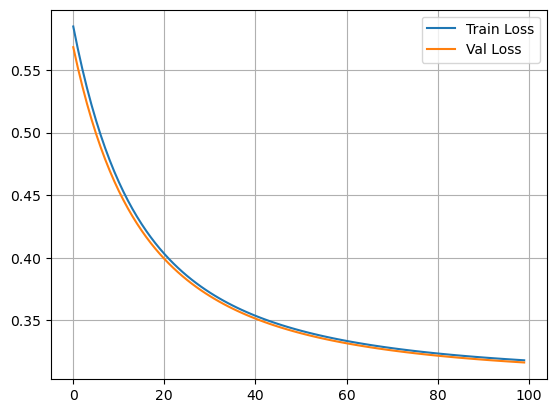

In [19]:
# Define the hyperparameters
num_inputs, num_outputs = X.shape[1], 1
num_epochs = 100
lr = 0.1

# Instantiate the model, opt, criterion
logreg = LogisticRegression(num_inputs, num_outputs)
optimizer = torch.optim.SGD(logreg.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []

# Train the model
for i in range(num_epochs):
    logreg.train()
    cost = 0
    for (X, y_true, fnc) in train_loader:
        optimizer.zero_grad()
        
        y_pred = logreg(X)
        
        loss = criterion(y_pred, y_true)
        
        cost += loss.item()
        
        loss.backward()
        optimizer.step()
        
        
    cost/=len(train_loader)
    train_losses.append(cost)
    
    val_cost = 0
    for (X, y_true, fnc) in val_loader:
        logreg.eval()
        
        y_pred = logreg(X)
        loss = criterion(y_pred, y_true)
        
        val_cost += loss.item()
        
        
    val_cost/=len(val_loader)
    val_losses.append(val_cost)
    
    print(f"Epoch {i}: train loss = {cost}, validation loss = {val_cost}")

# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.grid()
plt.show()

In [20]:
from sklearn.metrics import classification_report

logreg.eval()

train_true = []
train_pred = []

val_true = []
val_pred = []

test_true = []
test_pred = []

threshold = 0.5 

for (X, y_true, fnc) in train_loader:
    y_pred = torch.sigmoid(logreg(X)) 
    
    y_pred_binary = (y_pred >= threshold).float()

    train_true.extend(y_true) 
    train_pred.extend(y_pred_binary)

print("Train Data Results")
print(classification_report(train_true, train_pred, digits=4))


for (X, y_true, fnc) in val_loader:
    y_pred = torch.sigmoid(logreg(X)) 
    
    y_pred_binary = (y_pred >= threshold).float()

    val_true.extend(y_true) 
    val_pred.extend(y_pred_binary)

print("Val Data Results")
print(classification_report(val_true, val_pred, digits=4))


for (X, y_true, fnc) in test_loader:
    y_pred = torch.sigmoid(logreg(X)) 

    y_pred_binary = (y_pred >= threshold).float()

    test_true.extend(y_true) 
    test_pred.extend(y_pred_binary)

print("Test Data Results")
print(classification_report(test_true, test_pred, digits=4))


Train Data Results
              precision    recall  f1-score   support

         0.0     0.8962    0.9154    0.9057     72537
         1.0     0.7903    0.7505    0.7699     30808

    accuracy                         0.8662    103345
   macro avg     0.8433    0.8329    0.8378    103345
weighted avg     0.8647    0.8662    0.8652    103345

Val Data Results
              precision    recall  f1-score   support

         0.0     0.8980    0.9134    0.9056     15548
         1.0     0.7872    0.7555    0.7710      6597

    accuracy                         0.8663     22145
   macro avg     0.8426    0.8344    0.8383     22145
weighted avg     0.8650    0.8663    0.8655     22145

Test Data Results
              precision    recall  f1-score   support

         0.0     0.8913    0.9175    0.9042     15469
         1.0     0.7949    0.7408    0.7669      6677

    accuracy                         0.8642     22146
   macro avg     0.8431    0.8291    0.8355     22146
weighted avg     0.8

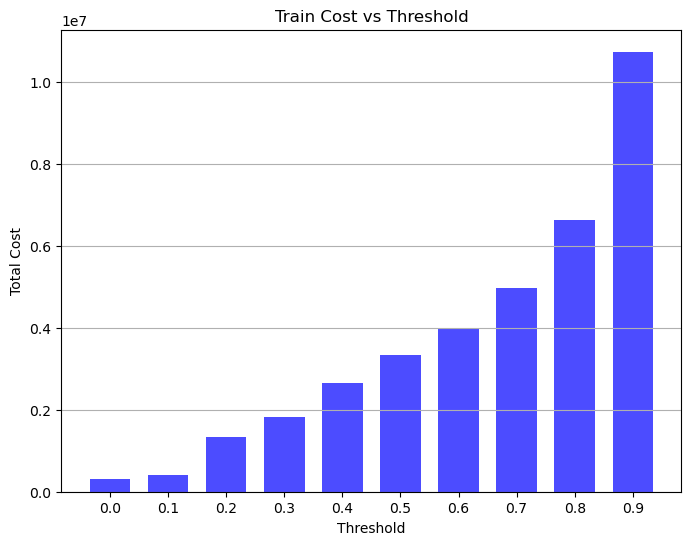

In [27]:
# Threshold vs cost?

tpc = 3      
fpc = 3      
tnc = 0      

thresholds = np.linspace(0.0, 0.9, 10)  
# thresholds = [0]
costs = []  

logreg.eval()


for threshold in thresholds:
    total_cost = 0  
    
    with torch.no_grad():
        for (X, y_true, fnc) in train_loader:
            X = X.to(torch.float32)
            
            y_pred = torch.sigmoid(logreg(X)) 
            
            y_pred_binary = (y_pred >= threshold).float()
            
            batch_cost = torch.sum(
                y_true * (y_pred_binary * tpc + (1 - y_pred_binary) * fnc) +
                (1 - y_true) * (y_pred_binary * fpc + (1 - y_pred_binary) * tnc)
            ).item()  
            
            total_cost += batch_cost  
    
    costs.append(total_cost)  

plt.figure(figsize=(8,6))
plt.bar(thresholds, costs, width=0.07, color='b', alpha=0.7)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Train Cost vs Threshold")
plt.xticks(thresholds)
plt.grid(axis='y')
plt.show()
